# Maximum Likelihood Estimation and Maximum A Posteriori estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def vander(X, K):
    res = np.ones((len(X), K))
    for i in range(1,K):
        res[:,i] = X**i
    return res

def split(X, Y, Ntrain):
    N = len(X)
    totalIdxs = np.arange(N)
    np.random.shuffle(totalIdxs)
    indecesTrain = totalIdxs[:Ntrain]
    indecesTest = totalIdxs[Ntrain:]
    Xtrain = X[indecesTrain]
    Ytrain = Y[indecesTrain]
    Xtest = X[indecesTest]
    Ytest = Y[indecesTest]
    return (Xtrain, Ytrain, Xtest, Ytest)

def dataset_normal(N, K, threshold=0.7, a=0, b=1, variance=0.1, plot=False):
    theta_true = np.ones((K,))
    X = np.linspace(a, b, N)
    phi = vander(X, K)
    Y = phi@theta_true
    train = round(N*0.7)
    noise = np.random.normal(0,variance,len(Y))
    Xtrain, Ytrain, Xtest, Ytest = split(X, Y+noise, train)
    D = (Xtrain,Ytrain)
    T = (Xtest, Ytest)

    if(plot == True):
        plt.figure(figsize=(3,3))
        plt.plot(X,Y+noise,"ro", markersize=3)
        plt.grid()
        plt.show()

    return D, T, theta_true

def abs_error(D,K, theta):
    X, Y = D
    N = len(X)
    phi = vander(X,K)
    return np.linalg.norm(phi@theta - Y,2)**2 / N

def err(theta, true):
    t = len(true)
    l = len(theta)
    pad_true = np.pad(true, (0,l-t), 'constant', constant_values=(0))
    return np.linalg.norm(theta - pad_true, 2) / np.linalg.norm(pad_true,2)

def plot_approximation(D, K, theta, a=0, b=1, points=1000, all=False, T=(), lam=[]):
    Xtrain,Ytrain = D
    #plt.figure(figsize=(5,5))
    plt.plot(Xtrain,Ytrain,"ro", markersize=3)
    if(all == True):
        Xtest,Ytest = T
        plt.plot(Xtest,Ytest,"bo", markersize=3)
        if(len(lam) > 0):
            for l in lam:
                theta_map = map(D, K, l, type="normal")
                XX = np.linspace(a,b,points)
                YY = vander(XX,K) @ theta_map
                plt.plot(XX, YY)
            plt.legend(["Train set","Test set"]+lam)
        else:
            XX = np.linspace(a,b,points)
            YY = vander(XX,K) @ theta
            plt.plot(XX, YY)
    else:
        XX = np.linspace(a,b,points)
        YY = vander(XX,K) @ theta
        plt.plot(XX, YY)
    plt.grid()
    plt.show()

In [3]:
def ell(theta, K, X, Y):
    return 0.5 * (np.linalg.norm(vander(X, K)@theta - Y)**2)

def grad_ell(theta, K, X, Y):
    return vander(X, K).T @ (((vander(X, K))@theta) - Y)

def ell_map(lam):
    return lambda theta, K, X, Y: 0.5 * ((np.linalg.norm(vander(X, K)@theta - Y)**2) + (lam/2) * np.linalg.norm(theta)**2)

def grad_ell_map(lam):
    return lambda theta, K, X, Y: vander(X, K).T @ ((vander(X, K) @ theta) - Y) + 2 * lam * theta

In [4]:
def GD(t0, D, K, tolf=1e-6, tolx=1e-6, kmax=1000, alpha=1e-2, f=ell, grad_f=grad_ell):
    (X, Y) = D

    tk = t0
    f_vals = [f(tk, K, X, Y)]
    grad_vals = [grad_f(tk, K, X, Y)]
    err_vals = [np.linalg.norm(grad_f(tk, K, X, Y))]
    t_vals = [tk]
    iteration = 0

    while iteration < kmax:
        t_prec = tk

        tk = t_prec - (alpha*grad_f(t_prec, K, X, Y))

        t_vals.append(tk)
        f_vals.append(f(tk, K, X, Y))
        grad_vals.append(grad_f(tk, K, X, Y))       
        err_vals.append(np.linalg.norm(grad_f(tk, K, X, Y)))

        iteration+=1

        if np.linalg.norm(grad_f(tk, K, X, Y)) < tolf:
            break

        if np.linalg.norm(tk - t_prec, 2) < tolx:
            break

    return tk

def SGD(t0, D, K, batch_size = 5, n_epochs = 10, alpha=1e-5, l=ell, grad_l=grad_ell):
    (X, Y) = D
    N = len(X)
    
    X_backup = X
    Y_backup = Y


    n_batch_per_epoch = N // batch_size
    t_vals = [t0]
    f_vals = [l(t0, K, X, Y)]
    grad_f_vals = [grad_l(t0, K, X, Y)]
    err_vals = [np.linalg.norm(grad_l(t0, K, X, Y))]

    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)

        for k in range(n_batch_per_epoch):
            batch_indices = idx[k * batch_size : (k + 1) * batch_size]

            Mx = X[batch_indices]
            My = Y[batch_indices]

            t = t_vals[-1] - alpha * grad_l(t_vals[-1], K, Mx, My)
            t_vals.append(t)

        
        X = X_backup
        Y = Y_backup
        f_vals.append(l(t, K, X, Y))
        grad_f_vals.append(grad_l(t, K, X, Y))
        err_vals.append(np.linalg.norm(grad_l(t, K, X, Y)))

    return t_vals[-1]

In [5]:
def mle(D, K, type="normal", var=0.1):
    (X,Y) = D
    phi = vander(X,K)
    theta = np.ones(K)

    match type:
        case "normal":
            theta_mle = np.linalg.solve(phi.T @ phi , phi.T @ Y) # use cholesky, first matrix is SPD
            # L = np.linalg.cholesky(phi.T @ phi)
            # y = np.linalg.solve(L,phi.T @ Y)
            # theta_mle = np.linalg.solve(L.T,y)
            return theta_mle
        case "GD":
            theta_zero = np.zeros((K,))
            theta = GD(theta_zero, D, K)
            return theta
        case "SGD":
            theta_zero = np.random.normal(1, var, K) # np.zeros(K)
            theta = SGD(theta_zero, D, K)
            return theta
        case _:
            print("Type not recognised")
            return theta
            

In [6]:
def map(D, K, lam=0.5, type="normal", var=0.1):
    (X,Y) = D
    phi = vander(X,K)
    theta = np.ones(K)

    match type:
        case "normal":
            theta_map = np.linalg.solve(phi.T @ phi + np.identity(K)*lam, phi.T @ Y) # use cholesky, first matrix is SPD
            # L = np.linalg.cholesky(phi.T @ phi + np.identity(K)*lam)        # for k >= 15 is not SPD.....?
            # y = np.linalg.solve(L,phi.T @ Y)
            # theta_map = np.linalg.solve(L.T,y)
            return theta_map
        case "GD":
            theta_zero = np.zeros((K,))
            theta = GD(theta_zero, D, K, f=ell_map(lam), grad_f=grad_ell_map(lam))
            return theta
        case "SGD":
            theta_zero = np.random.normal(1, var, K)
            theta = SGD(theta_zero, D, K, l=ell_map(lam), grad_l = grad_ell_map(lam))
            return theta
        case _:
            print("Type not recognised")
            return theta

## Initialization


In [7]:
N = 100
K = 4
D, T, theta_true= dataset_normal(N,K, variance=0.5,plot=False)

Xtrain, Ytrain = D
Xtest, Ytest = T

## MLE (Normal equations)

Absolute error on training set:  0.18677019026237476
Absolute error on test set:  0.7587047434637665
Err(theta):  18244560.062510166


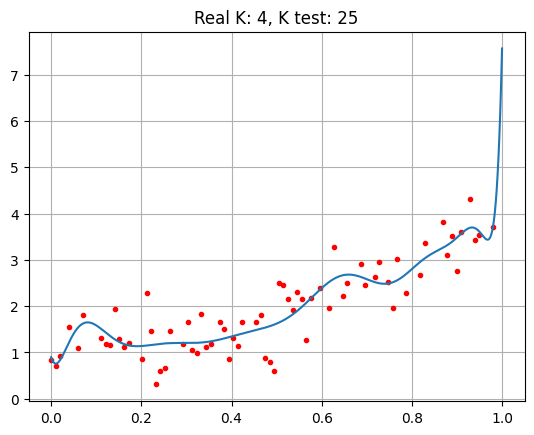

Absolute error on training set:  0.21282927439838784
Absolute error on test set:  0.2868011082827825
Err(theta):  3.353014727234819


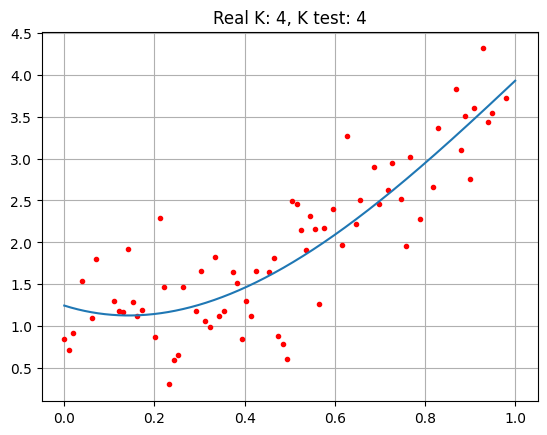

Absolute error on training set:  0.27867658304575665
Absolute error on test set:  0.29997803359211306


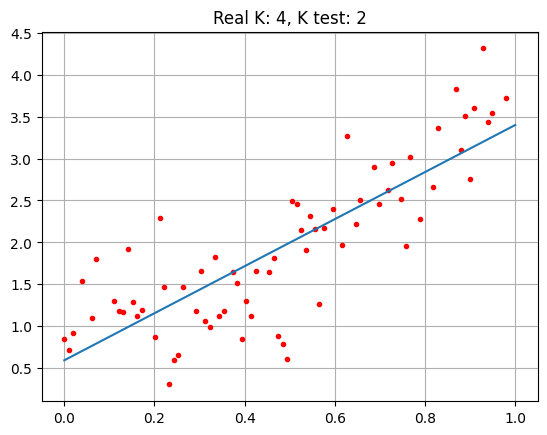

In [8]:
K_test = 25

theta_mle = mle(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)


K_test = 4

theta_mle = mle(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)

K_test = 2

theta_mle = mle(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)


The best tradeoff is given by K = 2


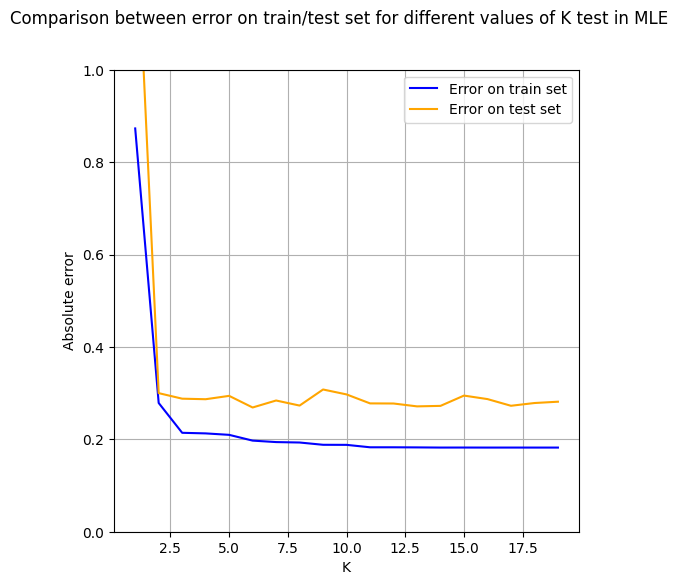

In [9]:
train_errors = []
test_errors = []
maxk = 20
for k in range(1, maxk):
    theta_mle = mle(D, k, type="normal")
    train_errors.append(abs_error(D,k,theta_mle))
    test_errors.append(abs_error(T,k,theta_mle))

dif = abs(np.array(train_errors) - np.array(test_errors))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)

x_plot = np.arange(1,maxk)
plt.figure(figsize=(6,6))
plt.suptitle("Comparison between error on train/test set for different values of K test in MLE")
plt.plot(x_plot, train_errors, color="blue")
plt.plot(x_plot, test_errors, color="orange")
plt.legend(["Error on train set","Error on test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.ylim(0,1)
plt.grid()
plt.show()

## MLE (GD)

Absolute error on training set:  0.2142874624474392
Absolute error on test set:  0.2899421909324726
Err(theta):  0.6174327792590779


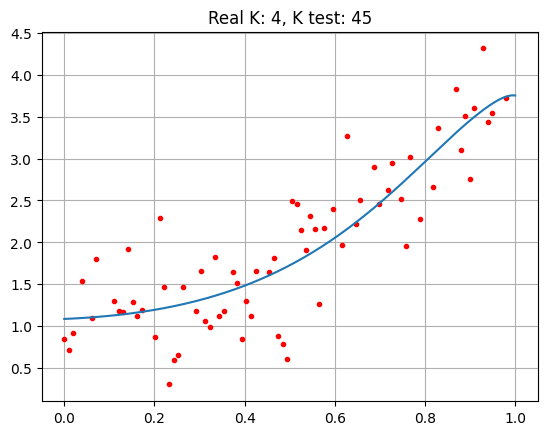

Absolute error on training set:  0.216439000520705
Absolute error on test set:  0.2879234694845025
Err(theta):  0.4620536528104526


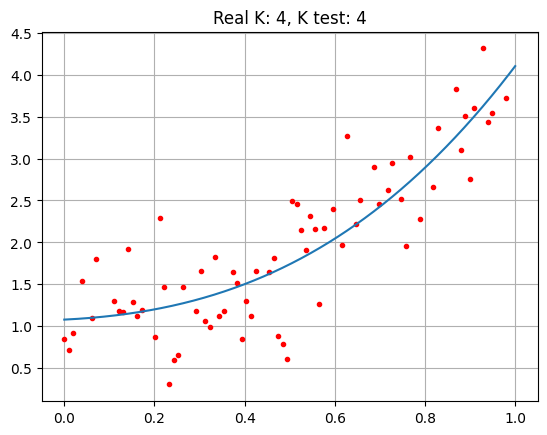

In [10]:
K_test = 45

theta_mle = mle(D, K_test, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)


K_test = 4

theta_mle = mle(D, K_test, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)

## MLE (SGD)

Absolute error on training set:  10.489722597611777
Absolute error on test set:  41.84744075267158
Err(theta):  2.3139269426069404


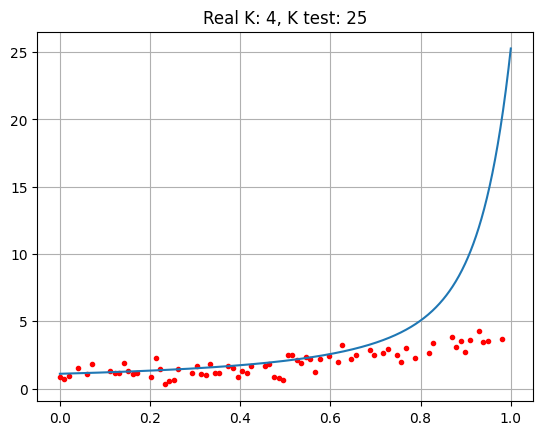

Absolute error on training set:  0.2584578996794976
Absolute error on test set:  0.26290728819942744
Err(theta):  0.15211806018532023


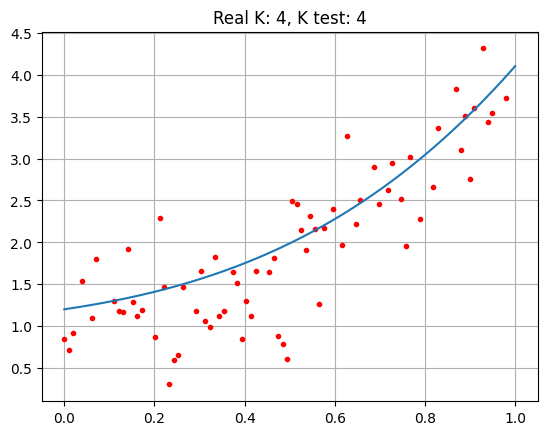

In [11]:
K_test = 25

theta_mle = mle(D, K_test, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)


K_test = 4

theta_mle = mle(D, K_test, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test))
plot_approximation(D, K_test, theta_mle)

## MAP (Normal equations)

Absolute error on training set:  0.1930981183580597
Absolute error on test set:  0.2730600727649428
Err(theta):  999.0182331099945


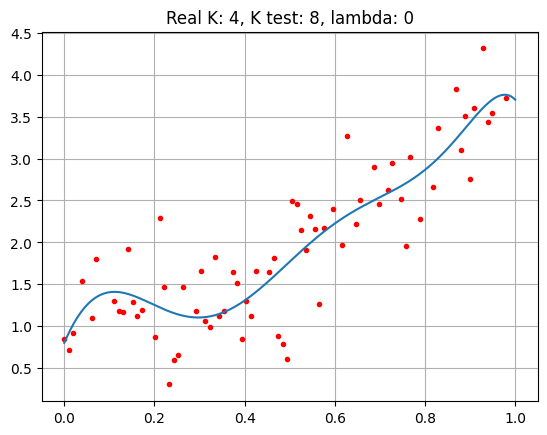

Absolute error on training set:  0.22018577382433513
Absolute error on test set:  0.28878312984521837
Err(theta):  0.3214554554974481


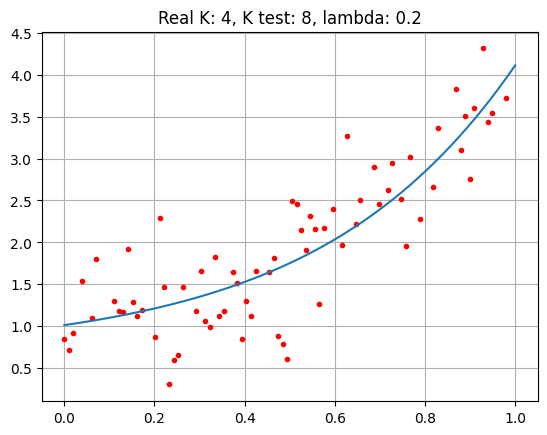

Absolute error on training set:  0.2186803944854733
Absolute error on test set:  0.29308563202434595
Err(theta):  0.38060930749009136


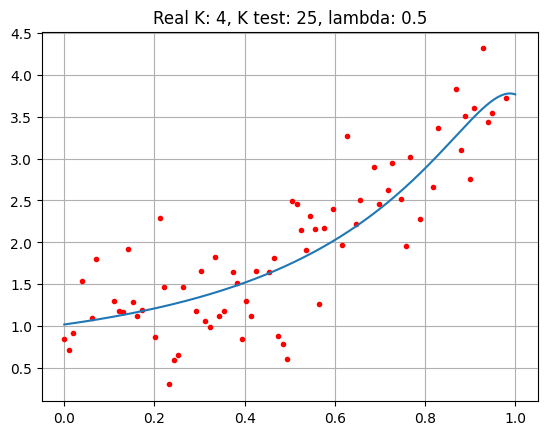

In [12]:
# Same K, different lambda (in first case = 0 -> mle)

K_test = 8
lam = 0

theta_map = map(D, K_test,lam, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test)+", lambda: "+str(lam))
plot_approximation(D, K_test, theta_map)

lam = 0.2
K_test = 8

theta_map = map(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test)+", lambda: "+str(lam))
plot_approximation(D, K_test, theta_map)

lam = 0.5
K_test = 25

theta_map = map(D, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plt.title("Real K: "+str(K)+", K test: "+str(K_test)+", lambda: "+str(lam))
plot_approximation(D, K_test, theta_map)

The best tradeoff is given by K = 2


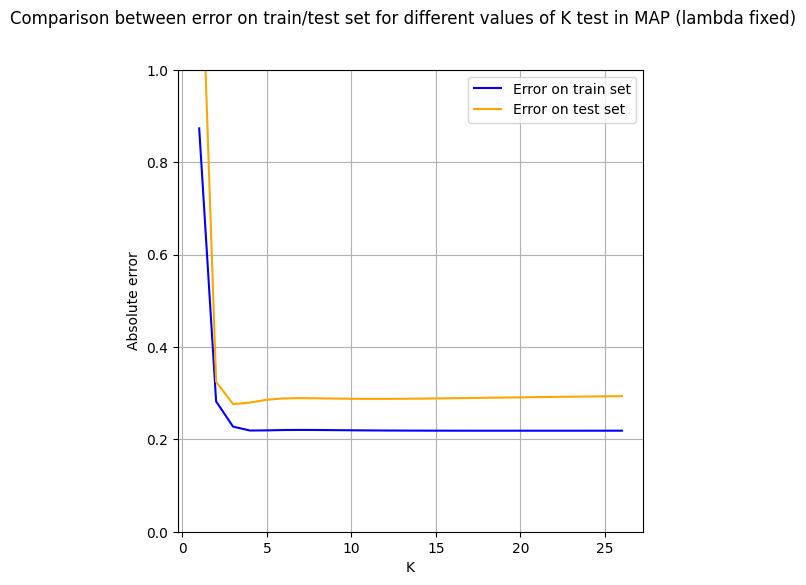

In [13]:
train_errors = []
test_errors = []
maxk = 27
for k in range(1, maxk):
    theta_map = map(D, k, type="normal")
    train_errors.append(abs_error(D,k,theta_map))
    test_errors.append(abs_error(T,k,theta_map))

dif = abs(np.array(train_errors) - np.array(test_errors))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)

x_plot = np.arange(1,maxk)
plt.figure(figsize=(6,6))
plt.suptitle("Comparison between error on train/test set for different values of K test in MAP (lambda fixed)")
plt.plot(x_plot, train_errors, color="blue")
plt.plot(x_plot, test_errors, color="orange")
plt.legend(["Error on train set","Error on test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.ylim(0,1)
plt.grid()
plt.show()

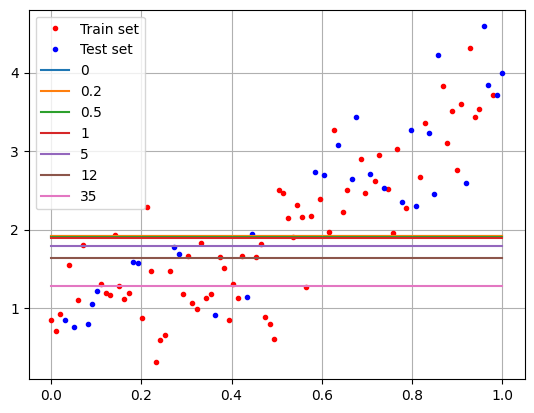

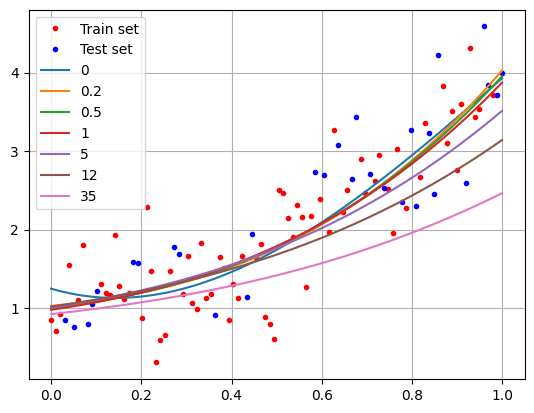

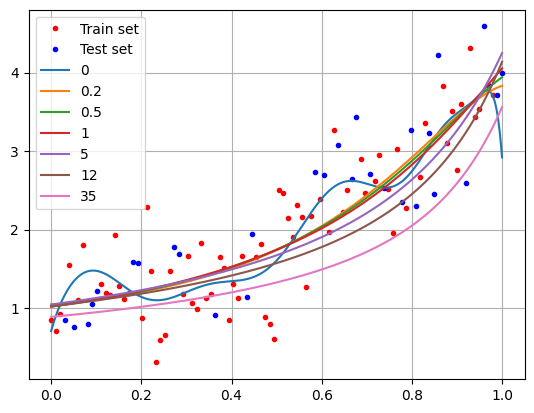

In [14]:
lam_values = [0, 0.2, 0.5, 1, 5, 12, 35]

K_test = 1
theta_map = map(D, K_test,lam, type="normal")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 4
theta_map = map(D, K_test, type="normal")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 15
theta_map = map(D, K_test, type="normal")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

## MAP (GD)

Absolute error on training set:  0.213935994261919
Absolute error on test set:  0.28381919518307497
Err(theta):  0.7013427590101141


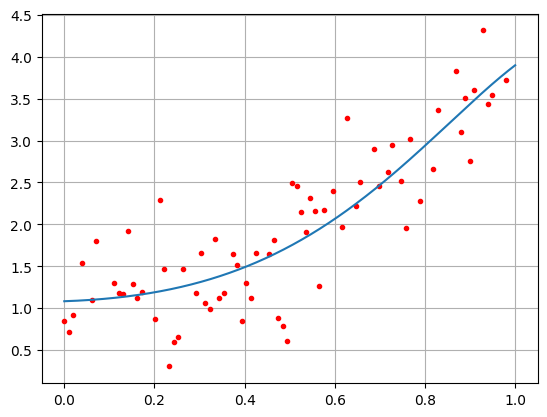

Absolute error on training set:  0.22231327832394485
Absolute error on test set:  0.2952816076401351
Err(theta):  0.3538153105079065


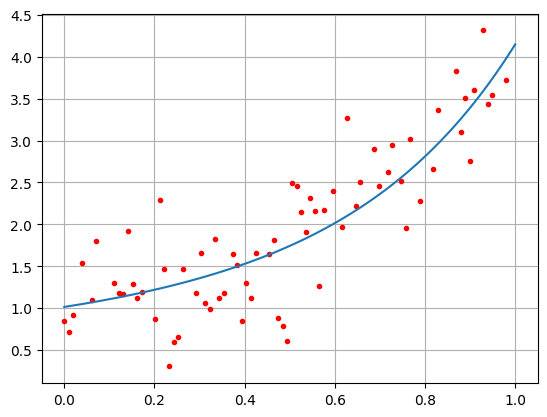

Absolute error on training set:  0.22072895713585056
Absolute error on test set:  0.29568094033449566
Err(theta):  0.38919472997664856


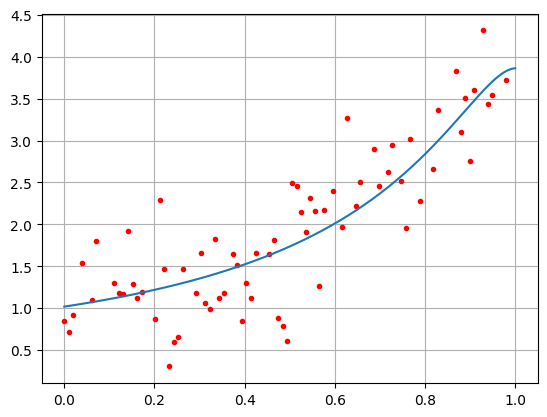

In [15]:
# Same K, different lambda (in first case = 0 -> mle)

K_test = 8
lam = 0

theta_map = map(D, K_test,lam, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

lam = 0.2
K_test = 8

theta_map = map(D, K_test, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

lam = 0.5
K_test = 25

theta_map = map(D, K_test, type="GD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

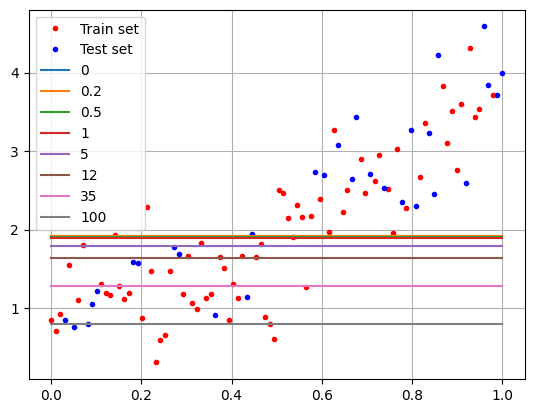

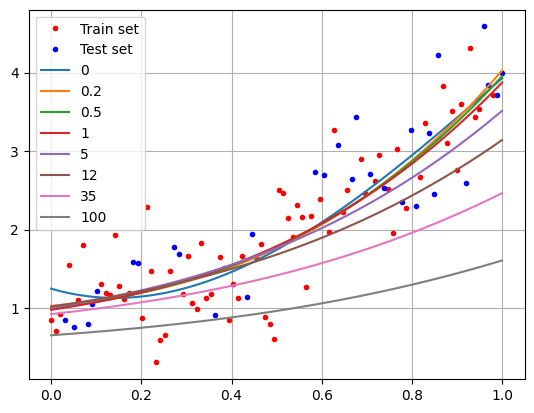

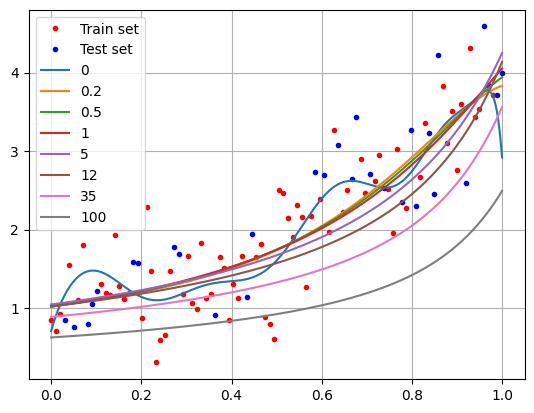

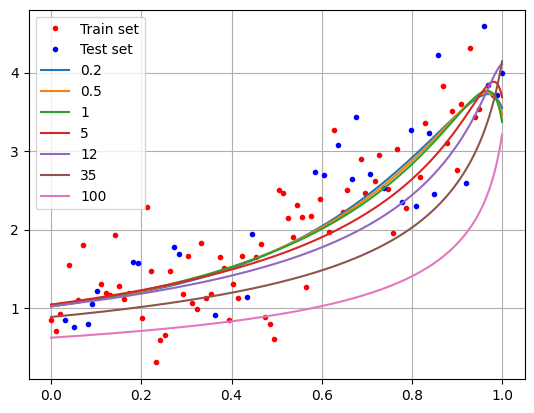

In [16]:
lam_values = [0, 0.2, 0.5, 1, 5, 12, 35, 100]

K_test = 1
theta_map = map(D, K_test,lam, type="GD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 4
theta_map = map(D, K_test, type="GD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 15
theta_map = map(D, K_test, type="GD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 110
theta_map = map(D, K_test, type="GD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values[1:])

## MAP (SGD)

Absolute error on training set:  1.3895783397862502
Absolute error on test set:  2.9541390406255035
Err(theta):  1.0503926334576086


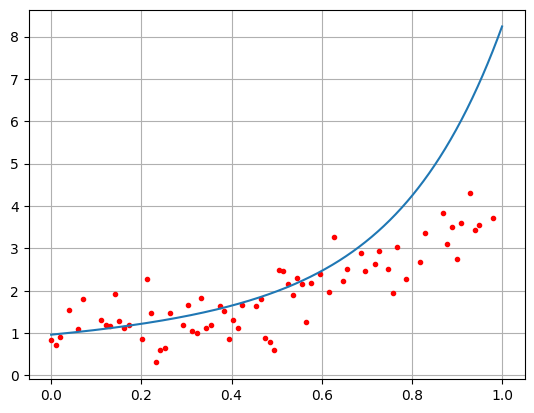

Absolute error on training set:  0.9686671967847806
Absolute error on test set:  2.0808891789664106
Err(theta):  0.9603232453040589


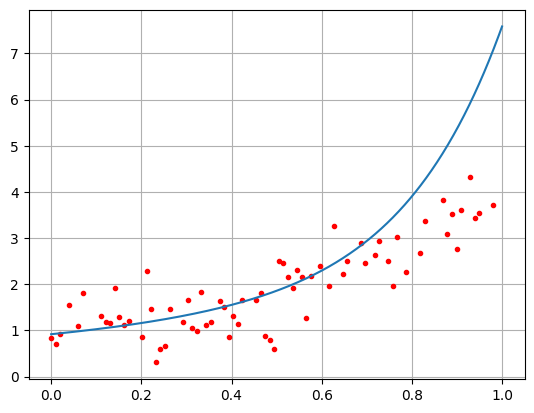

Absolute error on training set:  10.07601446729878
Absolute error on test set:  40.445132313937435
Err(theta):  2.296963344303392


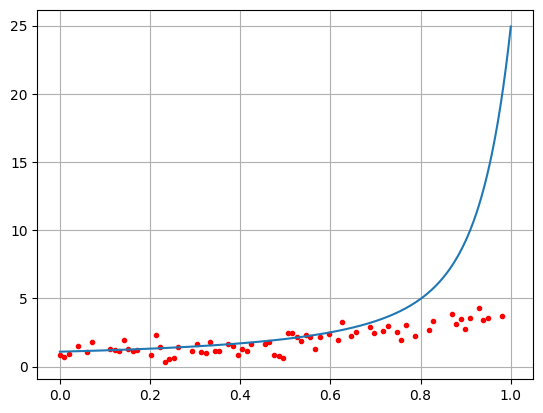

In [17]:
# Same K, different lambda (in first case = 0 -> mle)

K_test = 8
lam = 0

theta_map = map(D, K_test,lam, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

lam = 0.2
K_test = 8

theta_map = map(D, K_test, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

lam = 0.5
K_test = 25

theta_map = map(D, K_test, type="SGD")
print("Absolute error on training set: ",abs_error(D,K_test,theta_map))
print("Absolute error on test set: ",abs_error(T,K_test,theta_map))
print("Err(theta): ", err(theta_map, theta_true))
plot_approximation(D, K_test, theta_map)

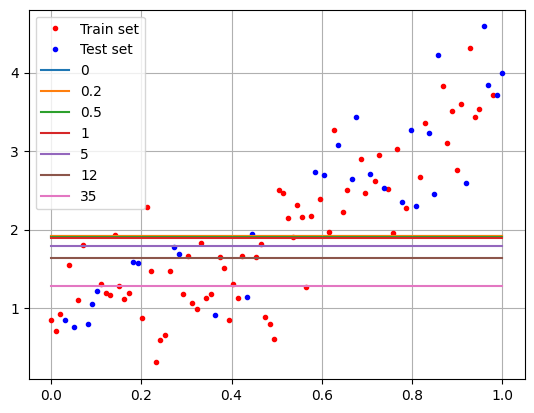

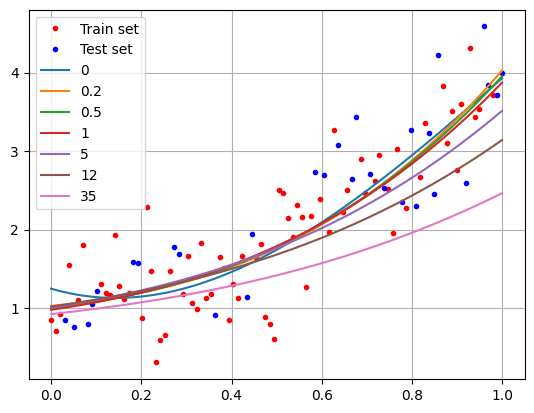

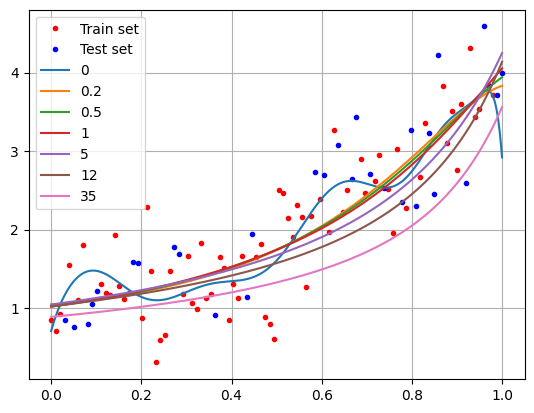

In [18]:
lam_values = [0, 0.2, 0.5, 1, 5, 12, 35]

K_test = 1
theta_map = map(D, K_test,lam, type="SGD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 4
theta_map = map(D, K_test, type="SGD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

K_test = 15
theta_map = map(D, K_test, type="SGD")
plot_approximation(D, K_test, theta_map, all=True, T=T, lam=lam_values)

## Different value of N

In [19]:
N2 = 1000
K2 = 4
D2, T2, theta_true2 = dataset_normal(N2,K2, variance=0.5,plot=False)

Xtrain, Ytrain = D2
Xtest, Ytest = T2

Absolute error on training set:  0.2744674112084921
Absolute error on test set:  0.21863632507211914
Err(theta):  2182151.215273367


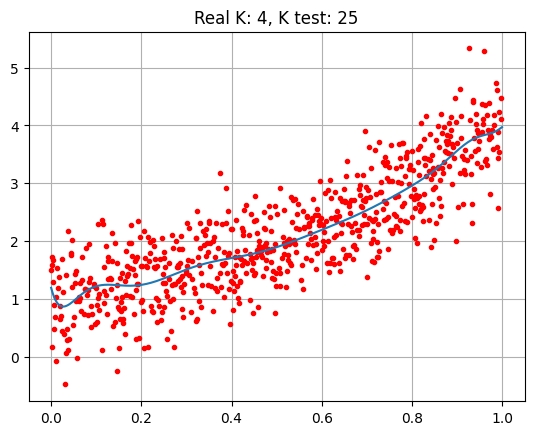

The best tradeoff is given by K = 1


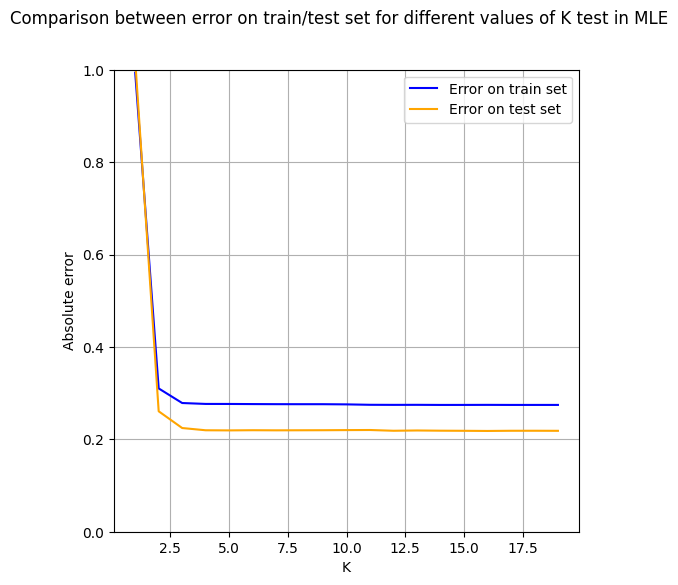

In [20]:
K_test = 25

theta_mle = mle(D2, K_test, type="normal")
print("Absolute error on training set: ",abs_error(D2,K_test,theta_mle))
print("Absolute error on test set: ",abs_error(T2,K_test,theta_mle))
print("Err(theta): ", err(theta_mle, theta_true2))
plt.title("Real K: "+str(K2)+", K test: "+str(K_test))
plot_approximation(D2, K_test, theta_mle)

train_errors = []
test_errors = []
maxk = 20
for k in range(1, maxk):
    theta_mle = mle(D2, k, type="normal")
    train_errors.append(abs_error(D2,k,theta_mle))
    test_errors.append(abs_error(T2,k,theta_mle))

dif = abs(np.array(train_errors) - np.array(test_errors))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)

x_plot = np.arange(1,maxk)
plt.figure(figsize=(6,6))
plt.suptitle("Comparison between error on train/test set for different values of K test in MLE")
plt.plot(x_plot, train_errors, color="blue")
plt.plot(x_plot, test_errors, color="orange")
plt.legend(["Error on train set","Error on test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.ylim(0,1)
plt.grid()
plt.show()

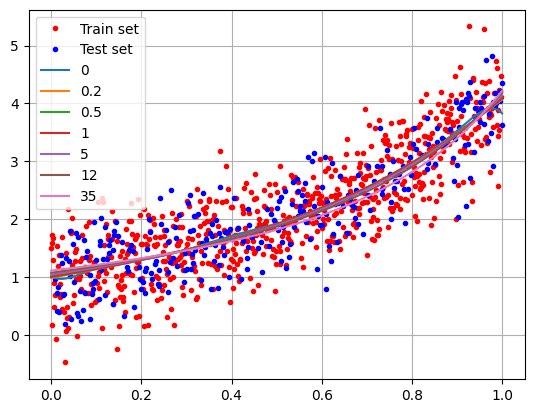

The best tradeoff is given by K = 1


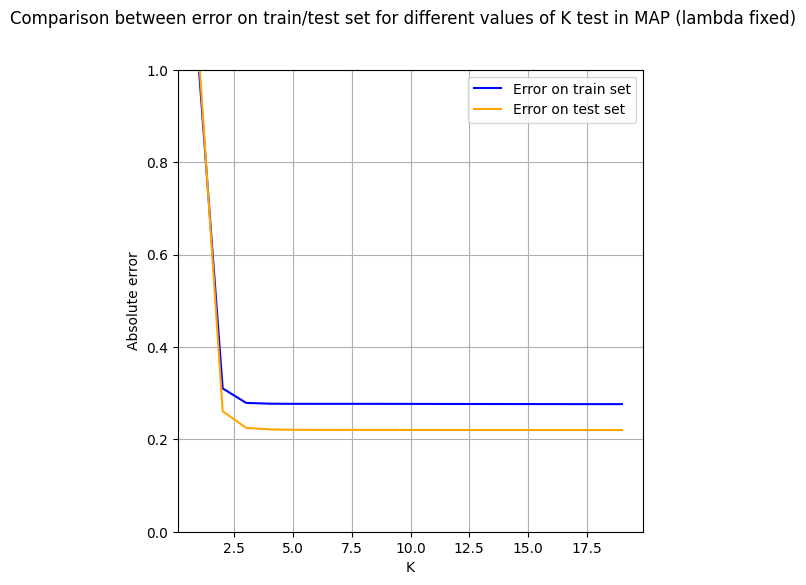

In [21]:
K_test = 10
theta_map = map(D2, K_test, type="normal")
plot_approximation(D2, K_test, theta_map, all=True, T=T2, lam=lam_values)

train_errors = []
test_errors = []
maxk = 20
for k in range(1, maxk):
    theta_map = map(D2, k, type="normal")
    train_errors.append(abs_error(D2,k,theta_map))
    test_errors.append(abs_error(T2,k,theta_map))

dif = abs(np.array(train_errors) - np.array(test_errors))
index = np.argmin(dif)+1
print("The best tradeoff is given by K =",index)

x_plot = np.arange(1,maxk)
plt.figure(figsize=(6,6))
plt.suptitle("Comparison between error on train/test set for different values of K test in MAP (lambda fixed)")
plt.plot(x_plot, train_errors, color="blue")
plt.plot(x_plot, test_errors, color="orange")
plt.legend(["Error on train set","Error on test set"])
plt.xlabel("K")
plt.ylabel("Absolute error")
plt.ylim(0,1)
plt.grid()
plt.show()